In [ ]:
# Import utils.py
!gdown 'https://drive.google.com/uc?id=13I5w4WajPg6MObtLPQjxznm8w5hKlEY0' -O ./utils.py
from utils import *

import os
import gdown
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import matplotlib.cm as cm

from sklearn.metrics import silhouette_score, confusion_matrix, adjusted_mutual_info_score, adjusted_rand_score
from sklearn.cluster import SpectralClustering
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from scipy.spatial import distance_matrix




Downloading...
From: https://drive.google.com/uc?id=13I5w4WajPg6MObtLPQjxznm8w5hKlEY0
To: /content/utils.py
100% 8.03k/8.03k [00:00<00:00, 16.5MB/s]


# Synthetic dataset

In [ ]:
# Upload on Google Colab, autoencoder for each omic 
ds_ae = {}     # this will contain each autoencoder trained on each omic
# Load autoencoders
!gdown 'https://drive.google.com/uc?id=1D_4E3muRg4ULC-0GQJRa8-XEcOwCFpUM' -O ./autoencoder_mRNA_synthetic.zip
!gdown 'https://drive.google.com/uc?id=1PGgUGB-_qQ44XBV6WlSkZanKRqXKn_zD' -O ./autoencoder_meth_synthetic.zip
!gdown 'https://drive.google.com/uc?id=1BZqv3_2qqBa4nPWT8RIGg82k-zKwvOeM' -O ./autoencoder_prot_synthetic.zip

!unzip autoencoder_mRNA_synthetic.zip
ds_ae["mRNA"] = tf.keras.models.load_model('autoencoder_mRNA_synthetic.tf')
!unzip autoencoder_meth_synthetic.zip
ds_ae["meth"] = tf.keras.models.load_model('autoencoder_meth_synthetic.tf')
!unzip autoencoder_prot_synthetic.zip
ds_ae["prot"] = tf.keras.models.load_model('autoencoder_prot_synthetic.tf')


Downloading...
From: https://drive.google.com/uc?id=1D_4E3muRg4ULC-0GQJRa8-XEcOwCFpUM
To: /content/autoencoder_mRNA_synthetic.zip
100% 1.65M/1.65M [00:00<00:00, 51.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PGgUGB-_qQ44XBV6WlSkZanKRqXKn_zD
To: /content/autoencoder_meth_synthetic.zip
2.55MB [00:00, 79.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BZqv3_2qqBa4nPWT8RIGg82k-zKwvOeM
To: /content/autoencoder_prot_synthetic.zip
100% 1.76M/1.76M [00:00<00:00, 56.5MB/s]
Archive:  autoencoder_mRNA_synthetic.zip
   creating: autoencoder_mRNA_synthetic.tf/
   creating: autoencoder_mRNA_synthetic.tf/variables/
  inflating: autoencoder_mRNA_synthetic.tf/variables/variables.index  
  inflating: autoencoder_mRNA_synthetic.tf/variables/variables.data-00000-of-00001  
   creating: autoencoder_mRNA_synthetic.tf/assets/
  inflating: autoencoder_mRNA_synthetic.tf/saved_model.pb  
  inflating: autoencoder_mRNA_synthetic.tf/keras_metadata.pb  
Archive:  autoencoder_meth_synthet

In [ ]:
# Load dataset
if not os.path.exists("./mRNA_synthetic.txt"):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=12PArkc1RsOm2437mbysxRF4hQMddZOsc' -O ./mRNA_synthetic.txt
if not os.path.exists("./meth_synthetic.txt"):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1aJkDF0ckxzY4vsnS53s-V89DdAnRVbPo' -O ./meth_synthetic.txt
if not os.path.exists("./prot_synthetic.txt"):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1iS4u1SZH6r_Dvs7qRSKC444kc_bqmGhJ' -O ./prot_synthetic.txt
if not os.path.exists("./clusters_synthetic.txt"):
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1UtHj4BzBx5hnQkkklJ9ugU5ERjLhjx4W' -O ./clusters_synthetic.txt

ds = {}     # this will contain each omic
omics = ['mRNA','meth','prot']
for omic_name in omics:
    path = omic_name + "_synthetic.txt"
    ds[omic_name] = pd.read_csv(path, sep='\t').drop(columns=["probe"]).T  


for omic in omics:
    if omic == "meth":
        mu = 0 
        sigma = 0.4 

    elif omic == "prot":
        mu = 0
        sigma = 4

    else:
        mu = 0
        sigma = 4
        
    n_samples, n_features = ds[omic].shape

    # Add salt & pepper noise
    np.random.seed(42)   # fixed seed for reproducibility
    noise = np.random.normal(mu, sigma, size=(n_samples, n_features))
    p = 0.5 #0.8     # salt & pepper noise: add (gaussian) noise to a particolar feature of a particular sample with probability p
    raveled_indices = np.random.choice(np.arange(n_samples*n_features), replace=False, size=int(n_samples*n_features*(1-p)))
    indices = np.unravel_index(raveled_indices, (n_samples, n_features))
    noise[indices] = 0

    print(f"Salt & pepper gaussian noise N({mu},{sigma**2}) is added to the {omic} dataset")
    ds[f'{omic}_noisy'] = ds[f'{omic}'] + noise

    # Normalize omic
    ds[f'{omic}_noisy'] = MinMaxScaler().fit_transform(ds[f'{omic}_noisy'])


y = pd.read_csv('clusters_synthetic.txt', sep='\t')    # this will contain the cluster assignment of each sample
y = y.reset_index().drop(labels='index', axis=1).set_index('subjects')
y.index.name = None
true_cluster_labels = y.values.reshape(y.shape[0])

--2021-07-15 14:49:42--  https://docs.google.com/uc?export=download&id=12PArkc1RsOm2437mbysxRF4hQMddZOsc
Resolving docs.google.com (docs.google.com)... 74.125.195.113, 74.125.195.138, 74.125.195.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/k2b6f48f38skrj44kj81ph8c9mf531li/1626360525000/05588580840073678935/*/12PArkc1RsOm2437mbysxRF4hQMddZOsc?e=download [following]
--2021-07-15 14:49:42--  https://doc-10-1g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/k2b6f48f38skrj44kj81ph8c9mf531li/1626360525000/05588580840073678935/*/12PArkc1RsOm2437mbysxRF4hQMddZOsc?e=download
Resolving doc-10-1g-docs.googleusercontent.com (doc-10-1g-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-10-1g-docs.googleusercontent.com (doc-10-1g-d

We can verify that despite introducing an even higher noise, our methods still performs well

Omic representations

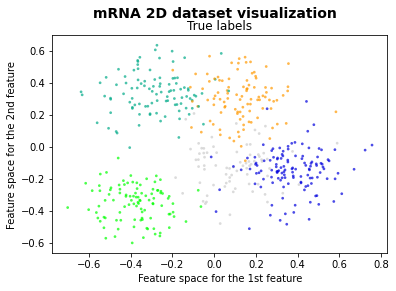

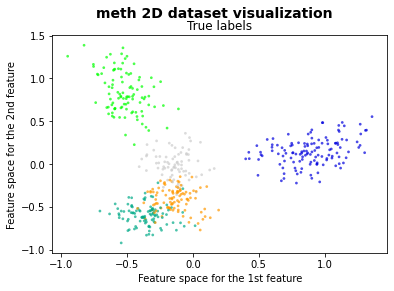

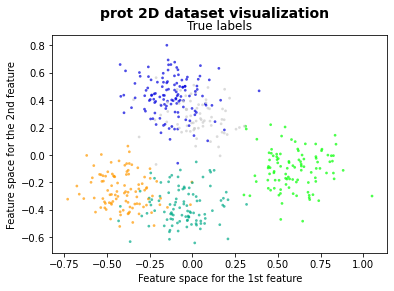

In [ ]:
for omic in omics:
    pca = PCA(n_components=2)
    pc2 = pca.fit_transform(ds[f'{omic}_noisy'],)
    plot_2D_dataset(pc2,true_cluster_labels,title=f'{omic} 2D dataset visualization',caption='True labels')

Early integration + K-means (For comparison)

Silhouette, 5 clusters: 0.06981902589489138


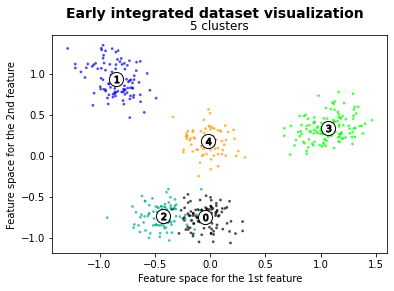

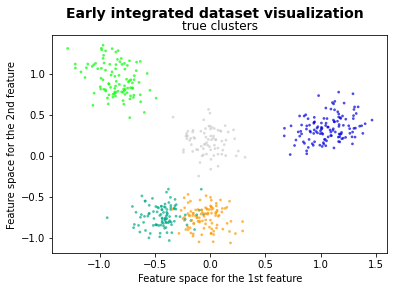

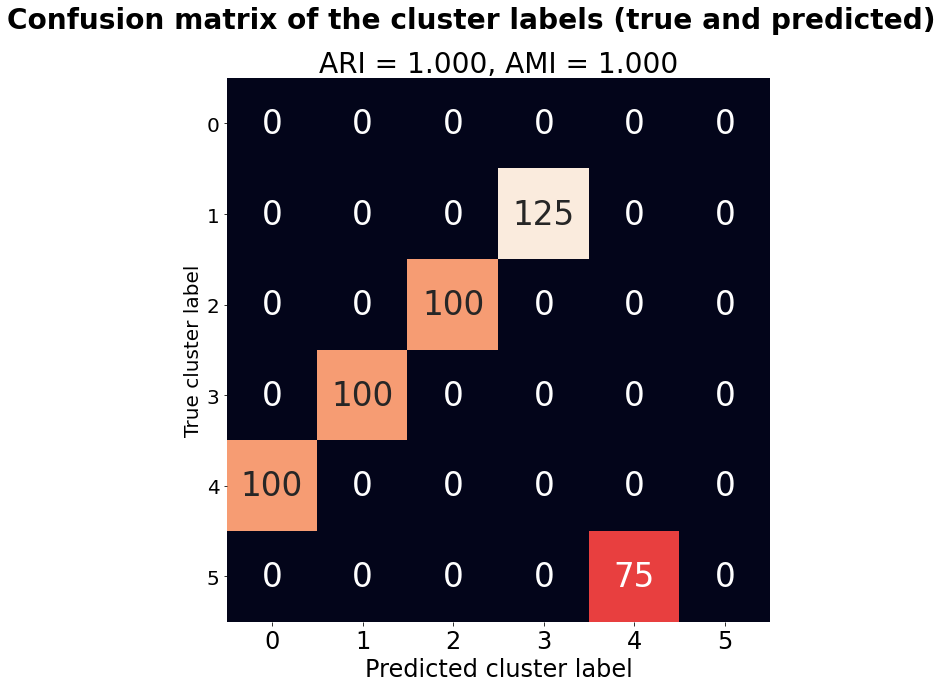

In [ ]:
# Concatenate the omics (early integration)
ds['early_integr'] = np.concatenate([ds[f'{omic}_noisy'] for omic in omics], axis=1)

kmeans = KMeans(n_clusters=5, random_state=0)
cluster_labels = kmeans.fit_predict(ds['early_integr'])

# Perform a 2D PCA to visualize the dataset
pca = PCA(2)
principalComponents = pca.fit_transform(ds['early_integr'])
kmeans.cluster_centers_ = pca.transform(kmeans.cluster_centers_)

# Compute silhouette on the original dataset with cluster assignments and true cluster labels
print(f"Silhouette, 5 clusters: {silhouette_score(ds['early_integr'], cluster_labels)}")

# Plot the clustered dataset with cluster assignments and true cluster labels
plot_2D_dataset(principalComponents, cluster_labels, cluster_centers=kmeans.cluster_centers_, title=f'Early integrated dataset visualization', caption=f'5 clusters')
plot_2D_dataset(principalComponents, true_cluster_labels, title=f'Early integrated dataset visualization', caption='true clusters')

# Plot the confusion matrix
plot_confusion_matrix(true_cluster_labels, cluster_labels)

## Integration method (w/ noise)

In [ ]:
# Find the latent space for each omic
ds_encoded = {}
for omic_name in omics:
    if omic_name not in ds_encoded:
        _, ds_encoded[omic_name] = ds_ae[omic_name](ds[f"{omic_name}_noisy"])

In [ ]:
# Compute the distance matrix for each encoded omic (and then average them together)
dist_mat = []
for omic in omics:
    dist_mat.append(distance_matrix(ds_encoded[omic], ds_encoded[omic]))
dist_mat = np.stack(dist_mat)

avg_dist_matrix = np.average(dist_mat, axis=0)

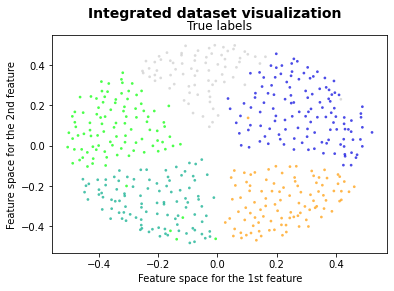

----- 2 CLUSTERS -----
silhouette: 0.061963009296315395


----- 3 CLUSTERS -----
silhouette: 0.07180683495645783


----- 4 CLUSTERS -----
silhouette: 0.06720813606800614


----- 5 CLUSTERS -----
silhouette: 0.07206787272236499


----- 6 CLUSTERS -----
silhouette: 0.05992503036379344


----- 7 CLUSTERS -----
silhouette: 0.05094181973732754


----- 8 CLUSTERS -----
silhouette: 0.034127374060390875


----- 9 CLUSTERS -----
silhouette: 0.0210562542227019


----- 10 CLUSTERS -----
silhouette: 0.020577605251394702


Best K found (standard avg integration): 5


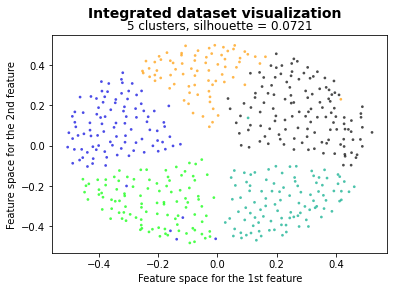

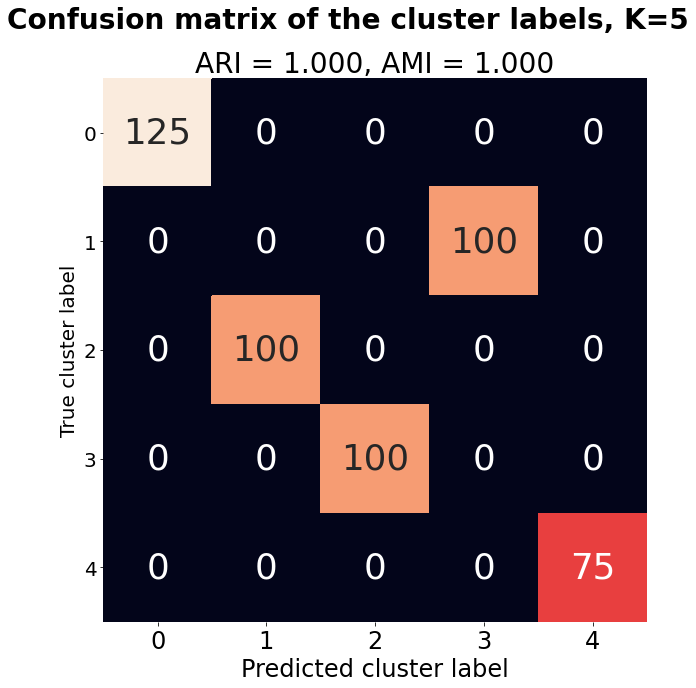

In [ ]:
#####
# Cluster with spectral clustering

embedding = MDS(n_components=2, dissimilarity='precomputed',random_state=0)
pc2 = embedding.fit_transform(avg_dist_matrix)
plot_2D_dataset(pc2, true_cluster_labels, title='Integrated dataset visualization', caption='True labels')

#####
# Results for the avg integration
best_K = 0
best_silh= -1

MAX_CLUSTERS = 10
for K in range(2, MAX_CLUSTERS+1):
    spectral = SpectralClustering(n_clusters=K, affinity='precomputed_nearest_neighbors', n_neighbors=8) # random_state=0
    cluster_assignments = spectral.fit_predict(avg_dist_matrix)
    silh = silhouette_score(avg_dist_matrix, cluster_assignments, metric="precomputed")
    if silh > best_silh:
        best_silh = silh
        best_K = K

    # Visualize clustering results and conf mat
    print(f"----- {K} CLUSTERS -----")
    print(f"silhouette: {silh}")
    print()
    print()

# Best result
print(f'Best K found (standard avg integration): {best_K}')
spectral = SpectralClustering(n_clusters=best_K, affinity='precomputed_nearest_neighbors', n_neighbors=8) # random_state=0
cluster_assignments = spectral.fit_predict(avg_dist_matrix)
plot_2D_dataset(pc2, cluster_assignments, title='Integrated dataset visualization', caption=f'{best_K} clusters, silhouette = {best_silh:.4f}')
plot_confusion_matrix(true_cluster_labels-1,cluster_assignments, title=f'Confusion matrix of the cluster labels, K={best_K}')
print()
print()
print()

# Synthetic dataset (no noise)

## Integration method (no noise)

In [ ]:
for omic in omics:
    # Normalize omic
    ds[f'{omic}_normalized'] = MinMaxScaler().fit_transform(ds[f'{omic}'])

Omic representations

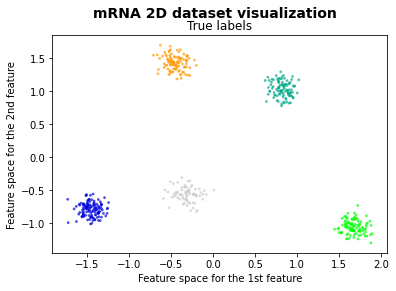

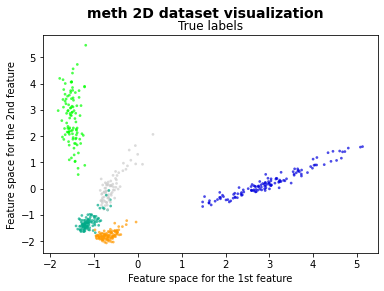

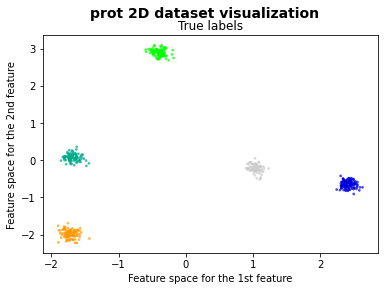

In [ ]:
for omic in omics:
    pca = PCA(n_components=2)
    pc2 = pca.fit_transform(ds[f'{omic}_normalized'],)
    plot_2D_dataset(pc2,true_cluster_labels,title=f'{omic} 2D dataset visualization',caption='True labels')

In [ ]:
# Find the latent space for each omic
ds_encoded = {}
for omic_name in omics:
    if omic_name not in ds_encoded:
        _, ds_encoded[omic_name] = ds_ae[omic_name](ds[f"{omic_name}_normalized"])

In [ ]:
# Compute the distance matrix for each encoded omic (and then average them together)
dist_mat = []
for omic in omics:
    dist_mat.append(distance_matrix(ds_encoded[omic], ds_encoded[omic]))
dist_mat = np.stack(dist_mat)

avg_dist_matrix = np.average(dist_mat, axis=0)

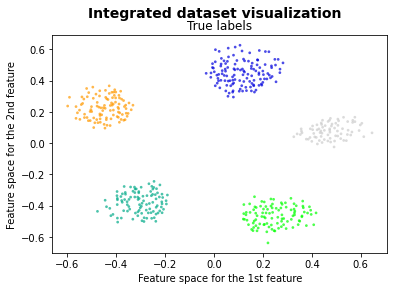

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


----- 2 CLUSTERS -----
silhouette: 0.2495824125996229


----- 3 CLUSTERS -----
silhouette: 0.313250422709835


----- 4 CLUSTERS -----
silhouette: 0.46127693408202236


----- 5 CLUSTERS -----
silhouette: 0.5405140056827904




/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


----- 6 CLUSTERS -----
silhouette: 0.2761220400038765


----- 7 CLUSTERS -----
silhouette: 0.1828534087197982




/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


----- 8 CLUSTERS -----
silhouette: 0.29791323222324306


----- 9 CLUSTERS -----
silhouette: -0.07550091253034262




/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


----- 10 CLUSTERS -----
silhouette: 0.01223708025956013


Best K found (standard avg integration): 5


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


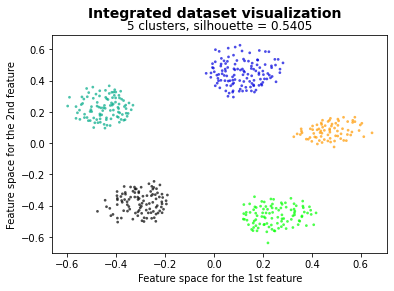

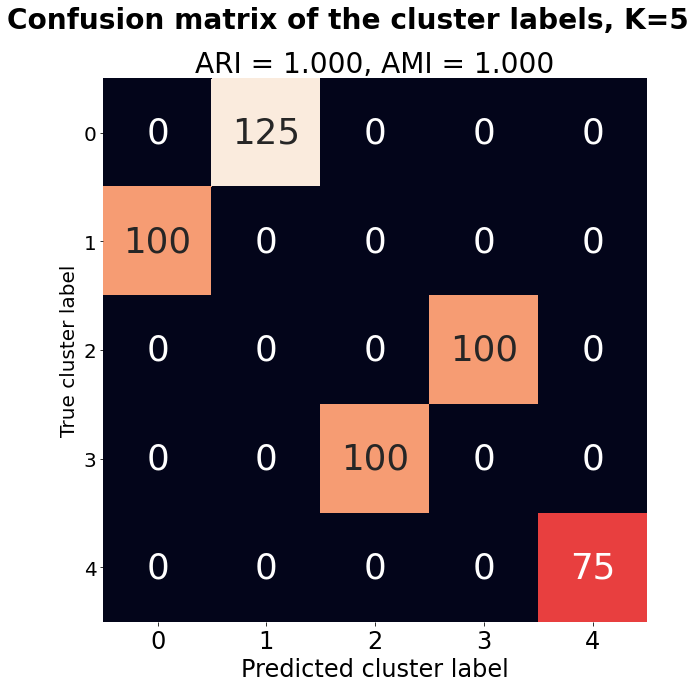

In [ ]:
#####
# Cluster with spectral clustering

embedding = MDS(n_components=2, dissimilarity='precomputed',random_state=0)
pc2 = embedding.fit_transform(avg_dist_matrix)
plot_2D_dataset(pc2, true_cluster_labels, title='Integrated dataset visualization', caption='True labels')

#####
# Results for the avg integration
best_K = 0
best_silh= -1

MAX_CLUSTERS = 10
for K in range(2, MAX_CLUSTERS+1):
    spectral = SpectralClustering(n_clusters=K, affinity='precomputed_nearest_neighbors', n_neighbors=8) # random_state=0
    cluster_assignments = spectral.fit_predict(avg_dist_matrix)
    silh = silhouette_score(avg_dist_matrix, cluster_assignments, metric="precomputed")
    if silh > best_silh:
        best_silh = silh
        best_K = K

    # Visualize clustering results and conf mat
    print(f"----- {K} CLUSTERS -----")
    print(f"silhouette: {silh}")
    print()
    print()

# Best result
print(f'Best K found (standard avg integration): {best_K}')
spectral = SpectralClustering(n_clusters=best_K, affinity='precomputed_nearest_neighbors', n_neighbors=8) # random_state=0
cluster_assignments = spectral.fit_predict(avg_dist_matrix)
plot_2D_dataset(pc2, cluster_assignments, title='Integrated dataset visualization', caption=f'{best_K} clusters, silhouette = {best_silh:.4f}')
plot_confusion_matrix(true_cluster_labels-1,cluster_assignments, title=f'Confusion matrix of the cluster labels, K={best_K}')
print()
print()
print()

# Lung dataset

In [ ]:
# Upload on Google Colab, autoencoder for each omic 
ds_ae = {}     # this will contain each autoencoder trained on each omic

# Load autoencoders
if not os.path.exists("./autoencoder_mRNA_lung.zip"):
    !gdown 'https://drive.google.com/uc?id=17pz12qMXWmoKwjmQGRwqGDMc8BzBZzAT' -O ./autoencoder_mRNA_lung.zip
if not os.path.exists("./autoencoder_miRNA_lung.zip"):
    !gdown 'https://drive.google.com/uc?id=16K2hzgnPvqd3bRHAzE_Pkj3Js23fIYlU' -O ./autoencoder_miRNA_lung.zip
if not os.path.exists("./autoencoder_meth_lung.zip"):
    !gdown 'https://drive.google.com/uc?id=1QEEiARWDeANMZ_Uoj2zHexz74eLNj2K8' -O ./autoencoder_meth_lung.zip
if not os.path.exists("./autoencoder_cnv_lung.zip"):
    !gdown 'https://drive.google.com/uc?id=1hgAqYL8fUJaYsAL5Gpx10_zNaRqqlsKO' -O ./autoencoder_cnv_lung.zip

!unzip autoencoder_mRNA_lung.zip
ds_ae["mRNA"] = tf.keras.models.load_model('autoencoder_mRNA_lung.tf')
!unzip autoencoder_miRNA_lung.zip
ds_ae["miRNA"] = tf.keras.models.load_model('autoencoder_miRNA_lung.tf')
!unzip autoencoder_meth_lung.zip
ds_ae["meth"] = tf.keras.models.load_model('autoencoder_meth_lung.tf')
!unzip autoencoder_cnv_lung.zip
ds_ae["cnv"] = tf.keras.models.load_model('autoencoder_cnv_lung.tf')


Archive:  autoencoder_mRNA_lung.zip
replace autoencoder_mRNA_lung.tf/variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: autoencoder_mRNA_lung.tf/variables/variables.index  
  inflating: autoencoder_mRNA_lung.tf/variables/variables.data-00000-of-00001  A

  inflating: autoencoder_mRNA_lung.tf/saved_model.pb  
  inflating: autoencoder_mRNA_lung.tf/keras_metadata.pb  
Archive:  autoencoder_miRNA_lung.zip
replace autoencoder_miRNA_lung.tf/variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: autoencoder_miRNA_lung.tf/variables/variables.index  
  inflating: autoencoder_miRNA_lung.tf/variables/variables.data-00000-of-00001  
  inflating: autoencoder_miRNA_lung.tf/saved_model.pb  
  inflating: autoencoder_miRNA_lung.tf/keras_metadata.pb  
Archive:  autoencoder_meth_lung.zip
replace autoencoder_meth_lung.tf/variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: autoencoder_meth_lung.tf/variables/variables.index  


In [ ]:
# Load dataset
if not os.path.exists("./mRNA_lung.txt"):
    !gdown 'https://drive.google.com/uc?id=1kNQxRoCs6TIGVzdlpEpUkAqx8FyoSrsi' -O ./mRNA_lung.txt
if not os.path.exists("./miRNA_lung.txt"):
    !gdown 'https://drive.google.com/uc?id=16V4tY8GeCUemOrf_KBqJwdixrQYZmFHv' -O ./miRNA_lung.txt
if not os.path.exists("./meth_lung.txt"):
    !gdown 'https://drive.google.com/uc?id=1UuCNcXbxHS1lW3bRkixsbo77xIFsWxIG' -O ./meth_lung.txt
if not os.path.exists("./cnv_lung.txt"):
    !gdown 'https://drive.google.com/uc?id=1RT1EiQCj19gGD8bYr0UBjxvUPl8473FX' -O ./cnv_lung.txt  # corrected for batch effects
if not os.path.exists("./clusters_lung.txt"):
    !gdown 'https://drive.google.com/uc?id=1t1rTrZNVHqZRo_F0YA0heD3WbvijHox7' -O ./clusters_lung.txt

ds = {}     # this will contain each omic
omics = ['mRNA','miRNA','meth','cnv']
for omic_name in omics:
    path = omic_name + "_lung.txt"
    if omic_name not in ds:
        ds[omic_name] = pd.read_csv(path, sep='\t', index_col=0)

y = pd.read_csv('clusters_lung.txt', sep='\t', index_col=0)
true_cluster_labels = y.values.reshape(y.shape[0])

### mRNA

In [ ]:
# Keep only protein coding genes
# NB: the file idx_mRNA_prot_cod.txt, containing the protein coding genes of the
# human genome, has been obtained in the colab notebook 'Find protein coding genes'
if not os.path.exists("./idx_mRNA_prot_cod_lung.txt"):
    !gdown 'https://drive.google.com/uc?id=1i6lXPIh60BtCF-ujfaqf4WrvWM4XMvNF' -O ./idx_mRNA_prot_cod_lung.txt

idx_mRNA_prot_cod = pd.read_csv('idx_mRNA_prot_cod_lung.txt')
idx_mRNA_prot_cod = idx_mRNA_prot_cod['idx'].values

ds['mRNA'] = ds['mRNA'].iloc[:, idx_mRNA_prot_cod]

# Delete genes with a zero expression value across all the samples
ds['mRNA'] = ds['mRNA'].loc[:, (ds['mRNA'] != 0).any(axis=0)]

# Normalize mRNA with MinMax Scaler
ds['mRNA_normalized'] = MinMaxScaler().fit_transform(ds['mRNA'].values)


### miRNA

In [ ]:
# Delete sequences with a zero expression value across all the samples
ds['miRNA'] = ds['miRNA'].loc[:, (ds['miRNA'] != 0).any(axis=0)]

# Normalize with log2 normalization
ds['miRNA'] = np.log(ds['miRNA'] + 1) / np.log(2)

# Normalize with MinMaxScaler
ds['miRNA_normalized'] = MinMaxScaler().fit_transform(ds['miRNA'].values)

### meth

In [ ]:
# Delete sequences with a zero expression value across all the samples
ds['meth'] = ds['meth'].loc[:, (ds['meth'] != 0).any(axis=0)]

# Normalize with MinMaxScaler
ds['meth_normalized'] = MinMaxScaler().fit_transform(ds['meth'].values)

### cnv

N.B.: batch effect correction has been performed on this omic (see 'Lung dataset retrieval' colab notebook);

Notice that, before applying the correction, as a pre-processing step we filtered out duplicates of each column, so to keep only one of each duplicate. This filters out a lot of genes.

The rationale behind this is that removing those columns preserves the distances between samples, while greatly reducing the dimensionality of the dataset.

In [ ]:
# Normalize with MinMaxScaler
ds['cnv_normalized'] = MinMaxScaler().fit_transform(ds['cnv'].values)

Omic representations

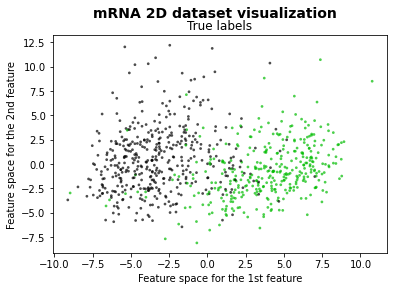

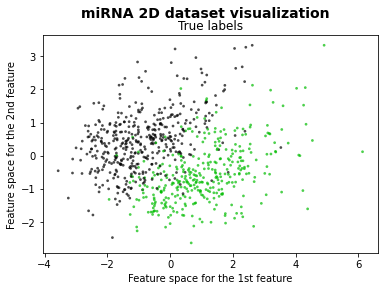

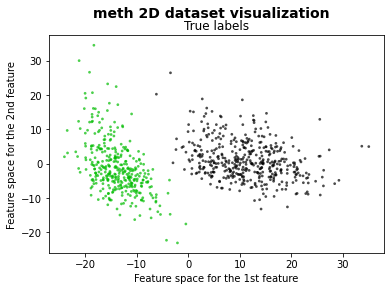

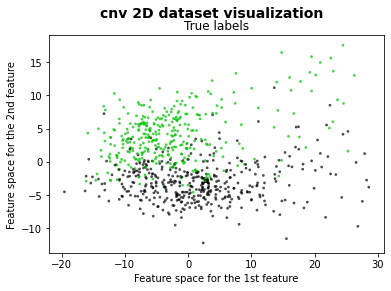

In [ ]:
for omic in omics:
    pca = PCA(n_components=2)
    pc2 = pca.fit_transform(ds[f'{omic}_normalized'],)
    plot_2D_dataset(pc2,true_cluster_labels,title=f'{omic} 2D dataset visualization',caption='True labels')

## Integration method

In [ ]:
# Find the latent space for each omic
ds_encoded = {}
for omic_name in omics:
    if omic_name not in ds_encoded:
        _, ds_encoded[omic_name] = ds_ae[omic_name](ds[f"{omic_name}_normalized"])

In [ ]:
# Compute the distance matrix for each encoded omic (and then average them together)
dist_mat = []
for omic in omics:
    dist_mat.append(distance_matrix(ds_encoded[omic], ds_encoded[omic]))
dist_mat = np.stack(dist_mat)

avg_dist_matrix = np.average(dist_mat, axis=0)

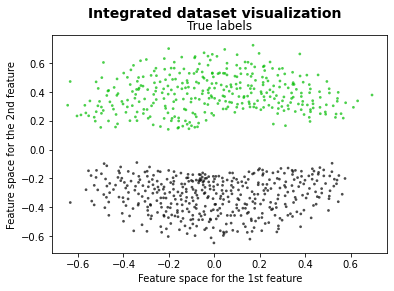

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


----- 2 CLUSTERS -----
silhouette: 0.30615481292429203


----- 3 CLUSTERS -----
silhouette: 0.1767376150833243




/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


----- 4 CLUSTERS -----
silhouette: 0.05417336737447395


----- 5 CLUSTERS -----
silhouette: 0.034394216867513094




/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


----- 6 CLUSTERS -----
silhouette: 0.036343722451704245


----- 7 CLUSTERS -----
silhouette: 0.037280836481426424




/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


----- 8 CLUSTERS -----
silhouette: 0.03144579764979756




/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


----- 9 CLUSTERS -----
silhouette: 0.029331359920446914




/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


----- 10 CLUSTERS -----
silhouette: 0.029750995679621053


Best K found (standard avg integration): 2


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


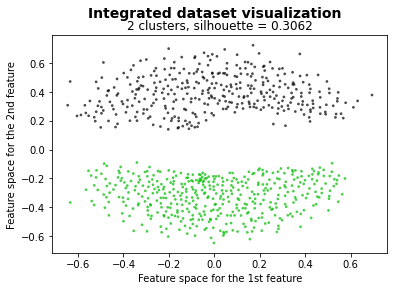

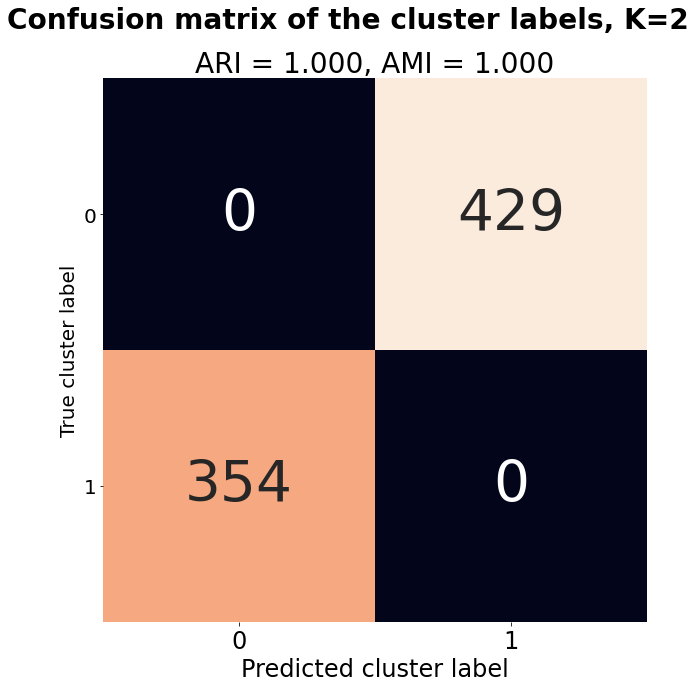

In [ ]:
#####
# Cluster with spectral clustering

embedding = MDS(n_components=2, dissimilarity='precomputed',random_state=0)
pc2 = embedding.fit_transform(avg_dist_matrix)
plot_2D_dataset(pc2, true_cluster_labels, title='Integrated dataset visualization', caption='True labels')

#####
# Results for the avg integration
best_K = 0
best_silh= -1

MAX_CLUSTERS = 10
for K in range(2, MAX_CLUSTERS+1):
    spectral = SpectralClustering(n_clusters=K, affinity='precomputed_nearest_neighbors', n_neighbors=8) # random_state=0
    cluster_assignments = spectral.fit_predict(avg_dist_matrix)
    silh = silhouette_score(avg_dist_matrix, cluster_assignments, metric="precomputed")
    if silh > best_silh:
        best_silh = silh
        best_K = K

    # Visualize clustering results and conf mat
    print(f"----- {K} CLUSTERS -----")
    print(f"silhouette: {silh}")
    print()
    print()

# Best result
print(f'Best K found (standard avg integration): {best_K}')
spectral = SpectralClustering(n_clusters=best_K, affinity='precomputed_nearest_neighbors', n_neighbors=8) # random_state=0
cluster_assignments = spectral.fit_predict(avg_dist_matrix)
plot_2D_dataset(pc2, cluster_assignments, title='Integrated dataset visualization', caption=f'{best_K} clusters, silhouette = {best_silh:.4f}')
plot_confusion_matrix(true_cluster_labels,cluster_assignments, title=f'Confusion matrix of the cluster labels, K={best_K}')
print()
print()
print()

# Lung dataset w/ noise

We can verify that when introducing some salt & pepper noise, our method still performs well

In [ ]:
for omic in omics:
    if omic == "mRNA":
        mu = 0 
        sigma = 4 

    elif omic == "miRNA":
        mu = 0
        sigma = 5

    elif omic == "meth":
        mu = 0
        sigma = 6 
    else:
        mu = 0
        sigma = 0.1
        
    n_samples, n_features = ds[omic].shape

    # Add salt & pepper noise
    np.random.seed(42)   # fixed seed for reproducibility
    noise = np.random.normal(mu, sigma, size=(n_samples, n_features))
    p = 0.5 #0.8     # salt & pepper noise: add (gaussian) noise to a particolar feature of a particular sample with probability p
    raveled_indices = np.random.choice(np.arange(n_samples*n_features), replace=False, size=int(n_samples*n_features*(1-p)))
    indices = np.unravel_index(raveled_indices, (n_samples, n_features))
    noise[indices] = 0

    print(f"Salt & pepper gaussian noise N({mu},{sigma**2}) is added to the {omic} dataset")
    ds[f'{omic}_noisy'] = ds[f'{omic}'] + noise

    # Normalize omic
    ds[f'{omic}_noisy'] = MinMaxScaler().fit_transform(ds[f'{omic}_noisy'])

Salt & pepper gaussian noise N(0,16) is added to the mRNA dataset
Salt & pepper gaussian noise N(0,25) is added to the miRNA dataset
Salt & pepper gaussian noise N(0,36) is added to the meth dataset
Salt & pepper gaussian noise N(0,0.010000000000000002) is added to the cnv dataset


Omic representations

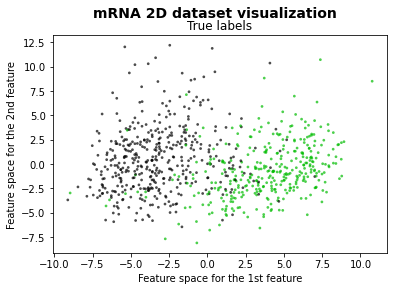

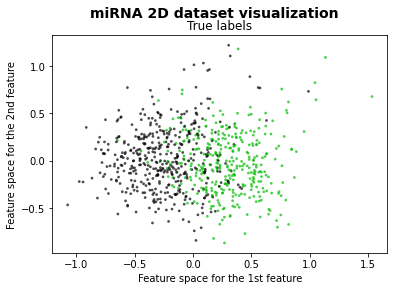

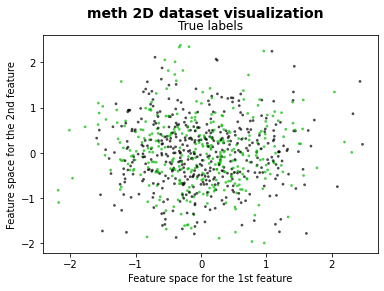

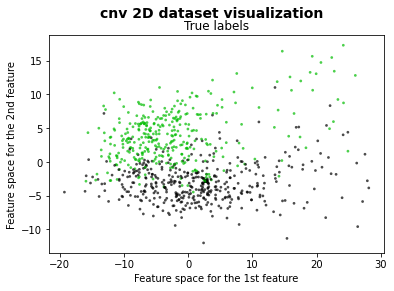

In [ ]:
for omic in omics:
    pca = PCA(n_components=2)
    pc2 = pca.fit_transform(ds[f'{omic}_noisy'])
    plot_2D_dataset(pc2,true_cluster_labels,title=f'{omic} 2D dataset visualization',caption='True labels')

Early integration + K-means (For comparison)

Silhouette, 2 clusters: 0.04992357167623901


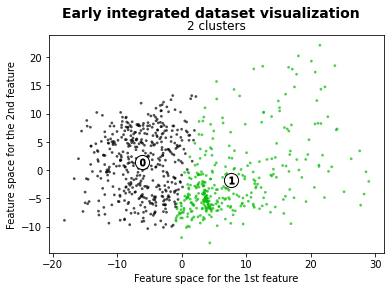

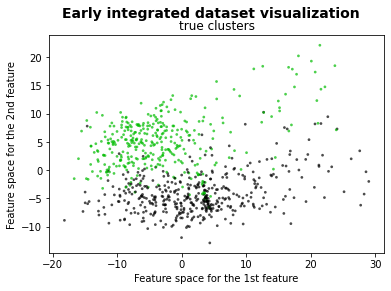

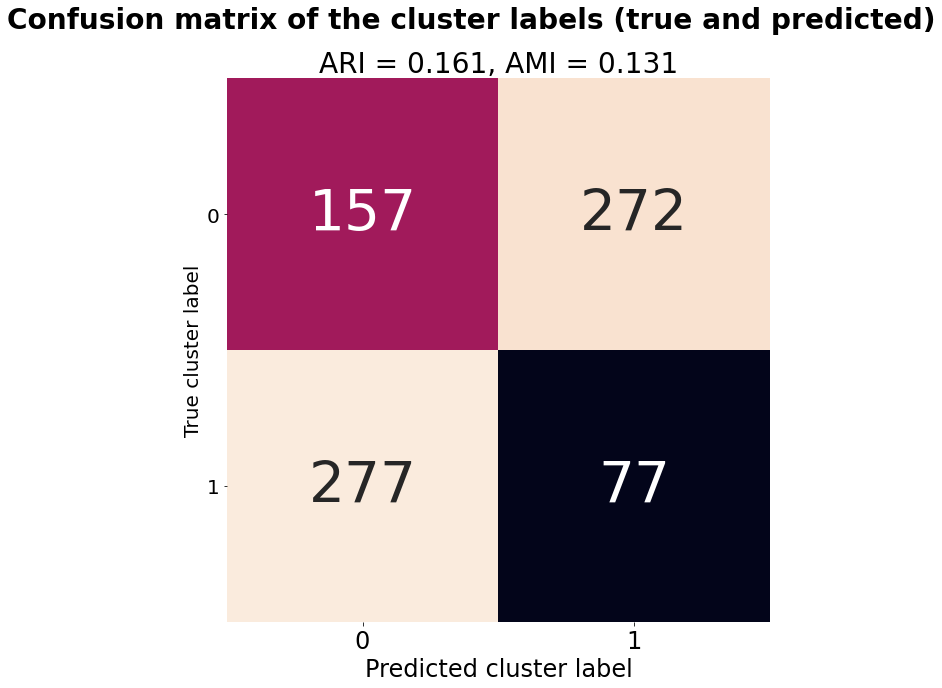

In [ ]:
# Concatenate the omics (early integration)
ds['early_integr'] = np.concatenate([ds[f'{omic}_noisy'] for omic in omics], axis=1)

kmeans = KMeans(n_clusters=2, random_state=0)
cluster_labels = kmeans.fit_predict(ds['early_integr'])

# Perform a 2D PCA to visualize the dataset
pca = PCA(2)
principalComponents = pca.fit_transform(ds['early_integr'])
kmeans.cluster_centers_ = pca.transform(kmeans.cluster_centers_)

# Compute silhouette on the original dataset with cluster assignments and true cluster labels
print(f"Silhouette, 2 clusters: {silhouette_score(ds['early_integr'], cluster_labels)}")

# Plot the clustered dataset with cluster assignments and true cluster labels
plot_2D_dataset(principalComponents, cluster_labels, cluster_centers=kmeans.cluster_centers_, title=f'Early integrated dataset visualization', caption='2 clusters')
plot_2D_dataset(principalComponents, true_cluster_labels, title=f'Early integrated dataset visualization', caption='true clusters')

# Plot the confusion matrix
plot_confusion_matrix(true_cluster_labels, cluster_labels)

## Integration method

In [ ]:
# Find the latent space for each omic
ds_encoded = {}
for omic_name in omics:
    if omic_name not in ds_encoded:
        _, ds_encoded[omic_name] = ds_ae[omic_name](ds[f"{omic_name}_noisy"])

In [ ]:
# Compute the distance matrix for each encoded omic (and then average them together)
dist_mat = []
for omic in omics:
    dist_mat.append(distance_matrix(ds_encoded[omic], ds_encoded[omic]))
dist_mat = np.stack(dist_mat)

avg_dist_matrix = np.average(dist_mat, axis=0)

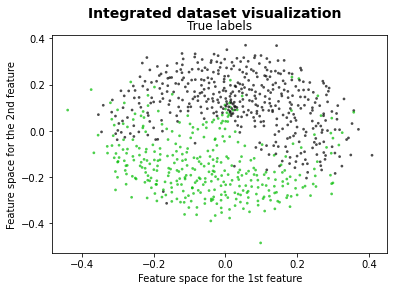

----- 2 CLUSTERS -----
silhouette: 0.10550871563833893


----- 3 CLUSTERS -----
silhouette: 0.08670439015608586


----- 4 CLUSTERS -----
silhouette: 0.05229210937120235


----- 5 CLUSTERS -----
silhouette: 0.03892434197576486


----- 6 CLUSTERS -----
silhouette: 0.027604473000313087


----- 7 CLUSTERS -----
silhouette: 0.018023368401524808


----- 8 CLUSTERS -----
silhouette: 0.016972699421460045


----- 9 CLUSTERS -----
silhouette: 0.019313506767393424


----- 10 CLUSTERS -----
silhouette: 0.01989498459691629


Best K found (standard avg integration): 2


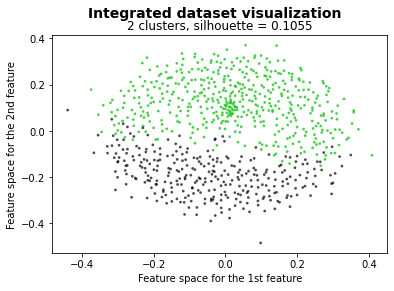

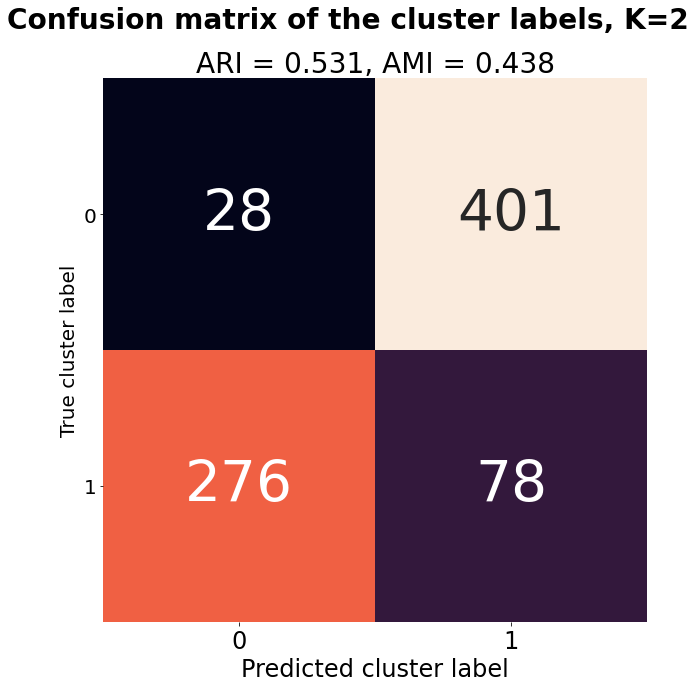

In [ ]:
#####
# Cluster with spectral clustering

embedding = MDS(n_components=2, dissimilarity='precomputed',random_state=0)
pc2 = embedding.fit_transform(avg_dist_matrix)
plot_2D_dataset(pc2, true_cluster_labels, title='Integrated dataset visualization', caption='True labels')

#####
# Results for the avg integration
best_K = 0
best_silh= -1

MAX_CLUSTERS = 10
for K in range(2, MAX_CLUSTERS+1):
    spectral = SpectralClustering(n_clusters=K, affinity='precomputed_nearest_neighbors', n_neighbors=8) # random_state=0
    cluster_assignments = spectral.fit_predict(avg_dist_matrix)
    silh = silhouette_score(avg_dist_matrix, cluster_assignments, metric="precomputed")
    if silh > best_silh:
        best_silh = silh
        best_K = K

    # Visualize clustering results and conf mat
    print(f"----- {K} CLUSTERS -----")
    print(f"silhouette: {silh}")
    print()
    print()

# Best result
print(f'Best K found (standard avg integration): {best_K}')
spectral = SpectralClustering(n_clusters=best_K, affinity='precomputed_nearest_neighbors', n_neighbors=8) # random_state=0
cluster_assignments = spectral.fit_predict(avg_dist_matrix)
plot_2D_dataset(pc2, cluster_assignments, title='Integrated dataset visualization', caption=f'{best_K} clusters, silhouette = {best_silh:.4f}')
plot_confusion_matrix(true_cluster_labels,cluster_assignments, title=f'Confusion matrix of the cluster labels, K={best_K}')
print()
print()
print()

# Kidney dataset

In [ ]:
# Upload on Google Colab, autoencoder for each omic 
ds_ae = {}     # this will contain each autoencoder trained on each omic

# Load autoencoders
if not os.path.exists("./autoencoder_mRNA_kidney.zip"):
    !gdown 'https://drive.google.com/uc?id=1Q3Dw-x_6lyXqmxJoHojBbrYRcgibtIkb' -O ./autoencoder_mRNA_kidney.zip
if not os.path.exists("./autoencoder_miRNA_kidney.zip"):
    !gdown 'https://drive.google.com/uc?id=1eo2ZKjEsmA7_mNQhP9m0mw3kIqyjazEy' -O ./autoencoder_miRNA_kidney.zip
if not os.path.exists("./autoencoder_meth_kidney.zip"):
    !gdown 'https://drive.google.com/uc?id=15RXyvNiovuG_G0Su2N0LuoqtNTYlqWdA' -O ./autoencoder_meth_kidney.zip

!unzip autoencoder_mRNA_kidney.zip
ds_ae["mRNA"] = tf.keras.models.load_model('autoencoder_mRNA_kidney.tf')
!unzip autoencoder_miRNA_kidney.zip
ds_ae["miRNA"] = tf.keras.models.load_model('autoencoder_miRNA_kidney.tf')
!unzip autoencoder_meth_kidney.zip
ds_ae["meth"] = tf.keras.models.load_model('autoencoder_meth_kidney.tf')


Downloading...
From: https://drive.google.com/uc?id=1Q3Dw-x_6lyXqmxJoHojBbrYRcgibtIkb
To: /content/autoencoder_mRNA_kidney.zip
283MB [00:05, 55.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eo2ZKjEsmA7_mNQhP9m0mw3kIqyjazEy
To: /content/autoencoder_miRNA_kidney.zip
100% 2.01M/2.01M [00:00<00:00, 31.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=15RXyvNiovuG_G0Su2N0LuoqtNTYlqWdA
To: /content/autoencoder_meth_kidney.zip
408MB [00:08, 50.8MB/s]
Archive:  autoencoder_mRNA_kidney.zip
   creating: autoencoder_mRNA_kidney.tf/
   creating: autoencoder_mRNA_kidney.tf/variables/
  inflating: autoencoder_mRNA_kidney.tf/variables/variables.index  
  inflating: autoencoder_mRNA_kidney.tf/variables/variables.data-00000-of-00001  
   creating: autoencoder_mRNA_kidney.tf/assets/
  inflating: autoencoder_mRNA_kidney.tf/saved_model.pb  
  inflating: autoencoder_mRNA_kidney.tf/keras_metadata.pb  
Archive:  autoencoder_miRNA_kidney.zip
   creating: autoencoder_miRNA_kidney.tf/
   

In [ ]:
# Load dataset
if not os.path.exists("./mRNA_kidney.txt"):
    !gdown 'https://drive.google.com/uc?id=1i1do_UTzwXzPVIDDmYSFJEholK2Mp8g_' -O ./mRNA_kidney.txt
if not os.path.exists("./miRNA_kidney.txt"):
    !gdown 'https://drive.google.com/uc?id=1liKeOBKjnbCi1CIjcOPA3Zxv2fRzCfa2' -O ./miRNA_kidney.txt
if not os.path.exists("./meth_kidney.txt"):
    !gdown 'https://drive.google.com/uc?id=1qr9joY0bAVDLvjWsKF5xf3CaRolBu-mP' -O ./meth_kidney.txt
if not os.path.exists("./clusters_kidney.txt"):
    !gdown 'https://drive.google.com/uc?id=1R-U2iDgM4oEyzNRfBIA2kXMbKw_s0QtI' -O ./clusters_kidney.txt

ds = {}     # this will contain each omic
omics = ['mRNA','miRNA','meth']
for omic_name in omics:
    path = omic_name + "_kidney.txt"
    if omic_name not in ds:
        ds[omic_name] = pd.read_csv(path, sep='\t', index_col=0)


y = pd.read_csv('clusters_kidney.txt', sep='\t', index_col=0)
true_cluster_labels = y.values.reshape(y.shape[0])

Downloading...
From: https://drive.google.com/uc?id=1i1do_UTzwXzPVIDDmYSFJEholK2Mp8g_
To: /content/mRNA_kidney.txt
386MB [00:05, 64.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1liKeOBKjnbCi1CIjcOPA3Zxv2fRzCfa2
To: /content/miRNA_kidney.txt
7.89MB [00:00, 25.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qr9joY0bAVDLvjWsKF5xf3CaRolBu-mP
To: /content/meth_kidney.txt
286MB [00:04, 70.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1R-U2iDgM4oEyzNRfBIA2kXMbKw_s0QtI
To: /content/clusters_kidney.txt
100% 25.4k/25.4k [00:00<00:00, 18.0MB/s]


### mRNA

In [ ]:
# Keep only protein coding genes
# NB: the file idx_mRNA_prot_cod.txt, containing the protein coding genes of the
# human genome, has been obtained in the colab notebook 'Find protein coding genes'
if not os.path.exists("./idx_mRNA_prot_cod_kidney.txt"):
    !gdown 'https://drive.google.com/uc?id=1Pi4u8y_YAc2tmOWZYaeLn9wGdzu4cFC5' -O ./idx_mRNA_prot_cod_kidney.txt

idx_mRNA_prot_cod = pd.read_csv('idx_mRNA_prot_cod_kidney.txt')
idx_mRNA_prot_cod = idx_mRNA_prot_cod['idx'].values

ds['mRNA'] = ds['mRNA'].iloc[:, idx_mRNA_prot_cod]

# Delete genes with a zero expression value across all the samples
ds['mRNA'] = ds['mRNA'].loc[:, (ds['mRNA'] != 0).any(axis=0)]

# Normalize mRNA with MinMax Scaler
ds['mRNA_normalized'] = MinMaxScaler().fit_transform(ds['mRNA'].values)

Downloading...
From: https://drive.google.com/uc?id=1Pi4u8y_YAc2tmOWZYaeLn9wGdzu4cFC5
To: /content/idx_mRNA_prot_cod_kidney.txt
100% 114k/114k [00:00<00:00, 40.0MB/s]


### miRNA

In [ ]:
# Delete sequences with a zero expression value across all the samples
ds['miRNA'] = ds['miRNA'].loc[:, (ds['miRNA'] != 0).any(axis=0)]

# Normalize with log2 normalization
ds['miRNA'] = np.log(ds['miRNA'] + 1) / np.log(2)

# Normalize with MinMaxScaler
ds['miRNA_normalized'] = MinMaxScaler().fit_transform(ds['miRNA'].values)

### meth

In [ ]:
# Delete sequences with a zero expression value across all the samples
ds['meth'] = ds['meth'].loc[:, (ds['meth'] != 0).any(axis=0)]

# Normalize with MinMaxScaler
ds['meth_normalized'] = MinMaxScaler().fit_transform(ds['meth'].values)

Omic representations

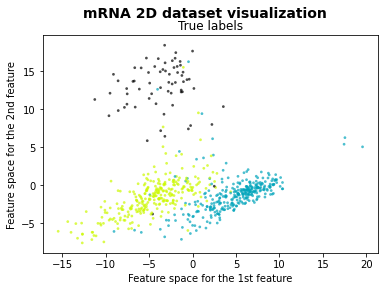

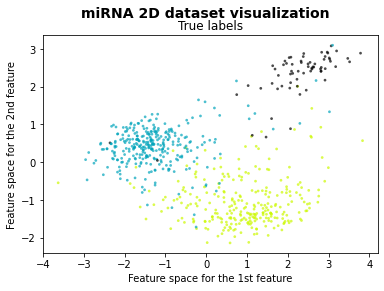

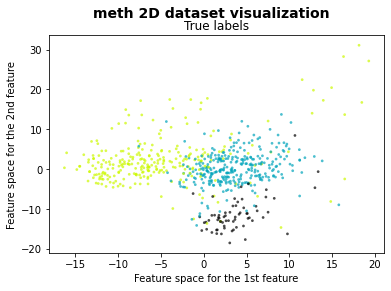

In [ ]:
for omic in omics:
    pca = PCA(n_components=2)
    pc2 = pca.fit_transform(ds[f'{omic}_normalized'])
    plot_2D_dataset(pc2,true_cluster_labels,title=f'{omic} 2D dataset visualization',caption='True labels')

## Integration method

In [ ]:
# Find the latent space for each omic
ds_encoded = {}
for omic_name in omics:
    if omic_name not in ds_encoded:
        _, ds_encoded[omic_name] = ds_ae[omic_name](ds[f"{omic_name}_normalized"])

In [ ]:
# Compute the distance matrix for each encoded omic (and then average them together)
dist_mat = []
for omic in omics:
    dist_mat.append(distance_matrix(ds_encoded[omic], ds_encoded[omic]))
dist_mat = np.stack(dist_mat)

avg_dist_matrix = np.average(dist_mat, axis=0)

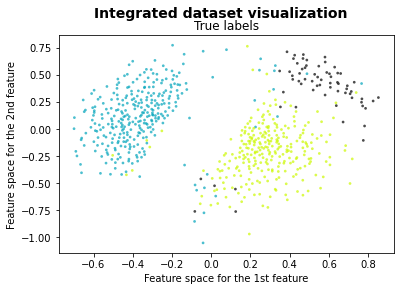

----- 2 CLUSTERS -----
silhouette: 0.31511081502015975


----- 3 CLUSTERS -----
silhouette: 0.32692723153203673


----- 4 CLUSTERS -----
silhouette: 0.18609717189132452


----- 5 CLUSTERS -----
silhouette: 0.1888707743812546


----- 6 CLUSTERS -----
silhouette: 0.11031830267841806


----- 7 CLUSTERS -----
silhouette: 0.11497140706853602


----- 8 CLUSTERS -----
silhouette: 0.0746044326712878


----- 9 CLUSTERS -----
silhouette: 0.06901420754200481


----- 10 CLUSTERS -----
silhouette: 0.060192108559098


Best K found (standard avg integration): 3


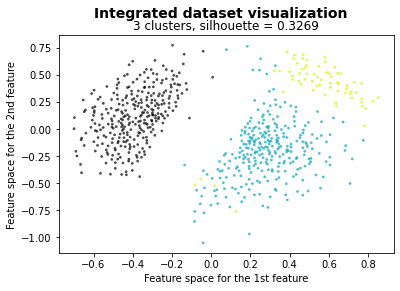

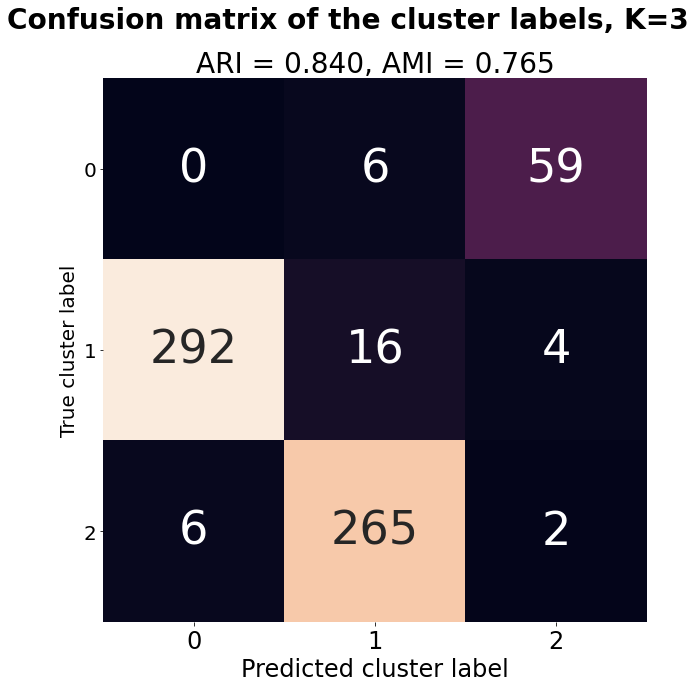

In [ ]:
#####
# Cluster with spectral clustering

embedding = MDS(n_components=2, dissimilarity='precomputed',random_state=0)
pc2 = embedding.fit_transform(avg_dist_matrix)
plot_2D_dataset(pc2, true_cluster_labels, title='Integrated dataset visualization', caption='True labels')

#####
# Results for the avg integration
best_K = 0
best_silh= -1

MAX_CLUSTERS = 10
for K in range(2, MAX_CLUSTERS+1):
    spectral = SpectralClustering(n_clusters=K, affinity='precomputed_nearest_neighbors', n_neighbors=8) # random_state=0
    cluster_assignments = spectral.fit_predict(avg_dist_matrix)
    silh = silhouette_score(avg_dist_matrix, cluster_assignments, metric="precomputed")
    if silh > best_silh:
        best_silh = silh
        best_K = K

    # Visualize clustering results and conf mat
    print(f"----- {K} CLUSTERS -----")
    print(f"silhouette: {silh}")
    print()
    print()

# Best result
print(f'Best K found (standard avg integration): {best_K}')
spectral = SpectralClustering(n_clusters=best_K, affinity='precomputed_nearest_neighbors', n_neighbors=8) # random_state=0
cluster_assignments = spectral.fit_predict(avg_dist_matrix)
plot_2D_dataset(pc2, cluster_assignments, title='Integrated dataset visualization', caption=f'{best_K} clusters, silhouette = {best_silh:.4f}')
plot_confusion_matrix(true_cluster_labels,cluster_assignments, title=f'Confusion matrix of the cluster labels, K={best_K}')
print()
print()
print()

# Kidney dataset (w/ noise)

We can verify that when introducing some salt & pepper noise, our method still performs well

In [ ]:
for omic in omics:
    if omic == "mRNA":
        mu = 0 
        sigma = 5

    elif omic == "miRNA":
        mu = 0
        sigma = 7

    elif omic == "meth":
        mu = 0
        sigma = 1
        
    n_samples, n_features = ds[omic].shape

    # Add salt & pepper noise
    np.random.seed(42)   # fixed seed for reproducibility
    noise = np.random.normal(mu, sigma, size=(n_samples, n_features))
    p = 0.5 #0.8     # salt & pepper noise: add (gaussian) noise to a particolar feature of a particular sample with probability p
    raveled_indices = np.random.choice(np.arange(n_samples*n_features), replace=False, size=int(n_samples*n_features*(1-p)))
    indices = np.unravel_index(raveled_indices, (n_samples, n_features))
    noise[indices] = 0

    print(f"Salt & pepper gaussian noise N({mu},{sigma**2}) is added to the {omic} dataset")
    ds[f'{omic}_noisy'] = ds[f'{omic}'] + noise

    # Normalize omic
    ds[f'{omic}_noisy'] = MinMaxScaler().fit_transform(ds[f'{omic}_noisy'])

Salt & pepper gaussian noise N(0,2500) is added to the mRNA dataset
Salt & pepper gaussian noise N(0,49) is added to the miRNA dataset
Salt & pepper gaussian noise N(0,1) is added to the meth dataset


Omic representations

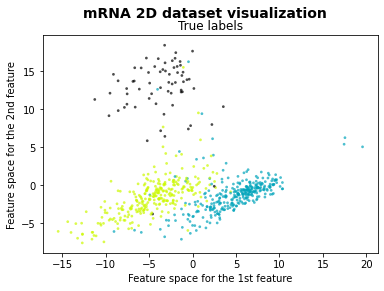

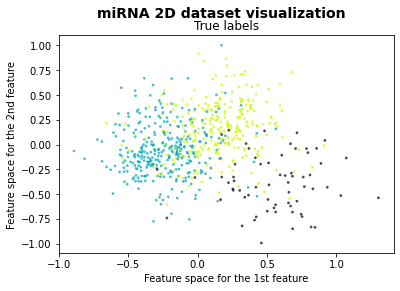

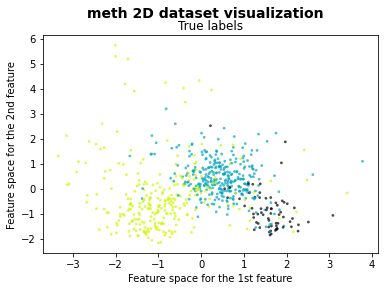

In [ ]:
for omic in omics:
    pca = PCA(n_components=2)
    pc2 = pca.fit_transform(ds[f'{omic}_noisy'])
    plot_2D_dataset(pc2,true_cluster_labels,title=f'{omic} 2D dataset visualization',caption='True labels')

Early integration + K-means (For comparison)

Silhouette, 3 clusters: 0.051329222835657926


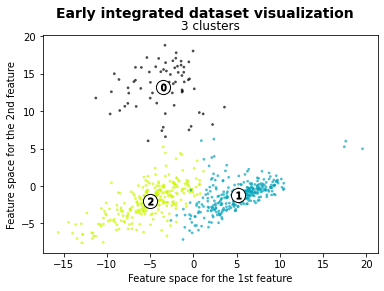

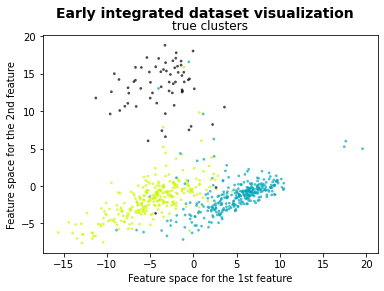

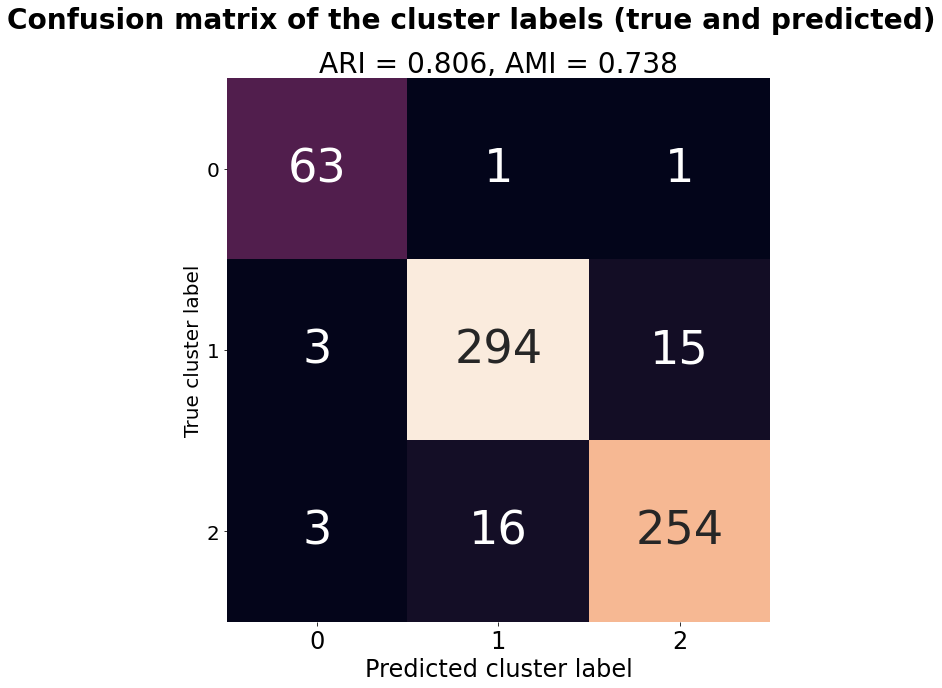

In [ ]:
# Concatenate the omics (early integration)
ds['early_integr'] = np.concatenate([ds[f'{omic}_noisy'] for omic in omics], axis=1)

kmeans = KMeans(n_clusters=3, random_state=0)
cluster_labels = kmeans.fit_predict(ds['early_integr'])

# Perform a 2D PCA to visualize the dataset
pca = PCA(2)
principalComponents = pca.fit_transform(ds['early_integr'])
kmeans.cluster_centers_ = pca.transform(kmeans.cluster_centers_)

# Compute silhouette on the original dataset with cluster assignments and true cluster labels
print(f"Silhouette, 3 clusters: {silhouette_score(ds['early_integr'], cluster_labels)}")

# Plot the clustered dataset with cluster assignments and true cluster labels
plot_2D_dataset(principalComponents, cluster_labels, cluster_centers=kmeans.cluster_centers_, title=f'Early integrated dataset visualization', caption='3 clusters')
plot_2D_dataset(principalComponents, true_cluster_labels, title=f'Early integrated dataset visualization', caption='true clusters')

# Plot the confusion matrix
plot_confusion_matrix(true_cluster_labels, cluster_labels)

## Integration method

In [ ]:
# Find the latent space for each omic
ds_encoded = {}
for omic_name in omics:
    if omic_name not in ds_encoded:
        _, ds_encoded[omic_name] = ds_ae[omic_name](ds[f"{omic_name}_noisy"])

In [ ]:
# Compute the distance matrix for each encoded omic (and then average them together)
dist_mat = []
for omic in omics:
    dist_mat.append(distance_matrix(ds_encoded[omic], ds_encoded[omic]))
dist_mat = np.stack(dist_mat)

avg_dist_matrix = np.average(dist_mat, axis=0)

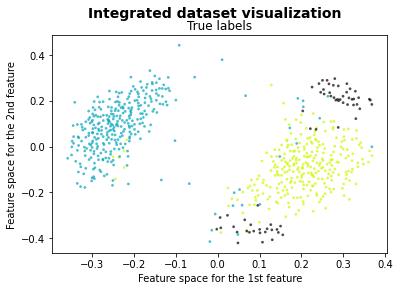

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


----- 2 CLUSTERS -----
silhouette: 0.19781842280751535


----- 3 CLUSTERS -----
silhouette: 0.4186356624981301




/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


----- 4 CLUSTERS -----
silhouette: 0.3071670865045892


----- 5 CLUSTERS -----
silhouette: 0.09472020479199215




/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


----- 6 CLUSTERS -----
silhouette: 0.07423897854723505


----- 7 CLUSTERS -----
silhouette: 0.05156632494351646




/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


----- 8 CLUSTERS -----
silhouette: 0.05910593965501521


----- 9 CLUSTERS -----
silhouette: 0.04948913449849214




/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


----- 10 CLUSTERS -----
silhouette: 0.04967942191047432


Best K found (standard avg integration): 3


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


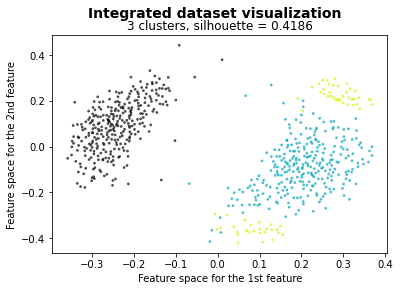

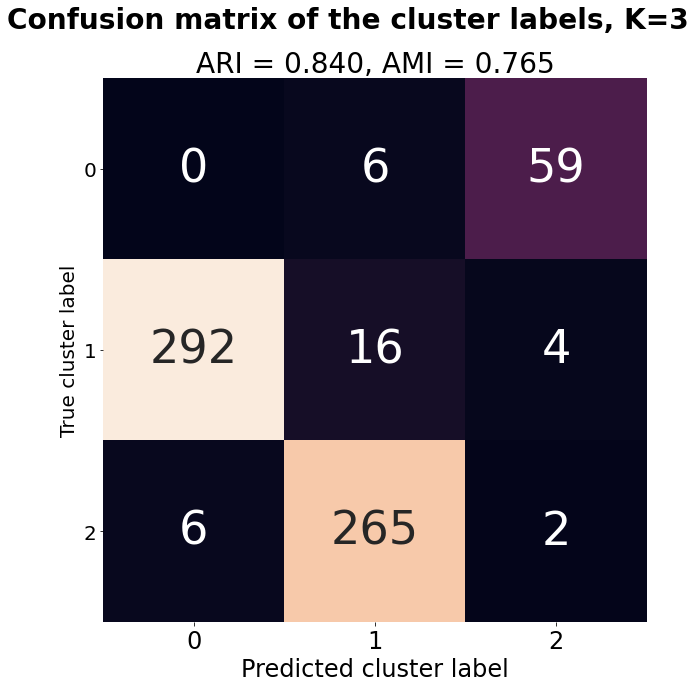

In [ ]:
#####
# Cluster with spectral clustering

embedding = MDS(n_components=2, dissimilarity='precomputed',random_state=0)
pc2 = embedding.fit_transform(avg_dist_matrix)
plot_2D_dataset(pc2, true_cluster_labels, title='Integrated dataset visualization', caption='True labels')

#####
# Results for the avg integration
best_K = 0
best_silh= -1

MAX_CLUSTERS = 10
for K in range(2, MAX_CLUSTERS+1):
    spectral = SpectralClustering(n_clusters=K, affinity='precomputed_nearest_neighbors', n_neighbors=8) # random_state=0
    cluster_assignments = spectral.fit_predict(avg_dist_matrix)
    silh = silhouette_score(avg_dist_matrix, cluster_assignments, metric="precomputed")
    if silh > best_silh:
        best_silh = silh
        best_K = K

    # Visualize clustering results and conf mat
    print(f"----- {K} CLUSTERS -----")
    print(f"silhouette: {silh}")
    print()
    print()

# Best result
print(f'Best K found (standard avg integration): {best_K}')
spectral = SpectralClustering(n_clusters=best_K, affinity='precomputed_nearest_neighbors', n_neighbors=8) # random_state=0
cluster_assignments = spectral.fit_predict(avg_dist_matrix)
plot_2D_dataset(pc2, cluster_assignments, title='Integrated dataset visualization', caption=f'{best_K} clusters, silhouette = {best_silh:.4f}')
plot_confusion_matrix(true_cluster_labels,cluster_assignments, title=f'Confusion matrix of the cluster labels, K={best_K}')
print()
print()
print()